In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import matplotlib as mpl
import numpy as np
import scipy as sp
import json
import sys

In [3]:
plt.style.use('ggplot')

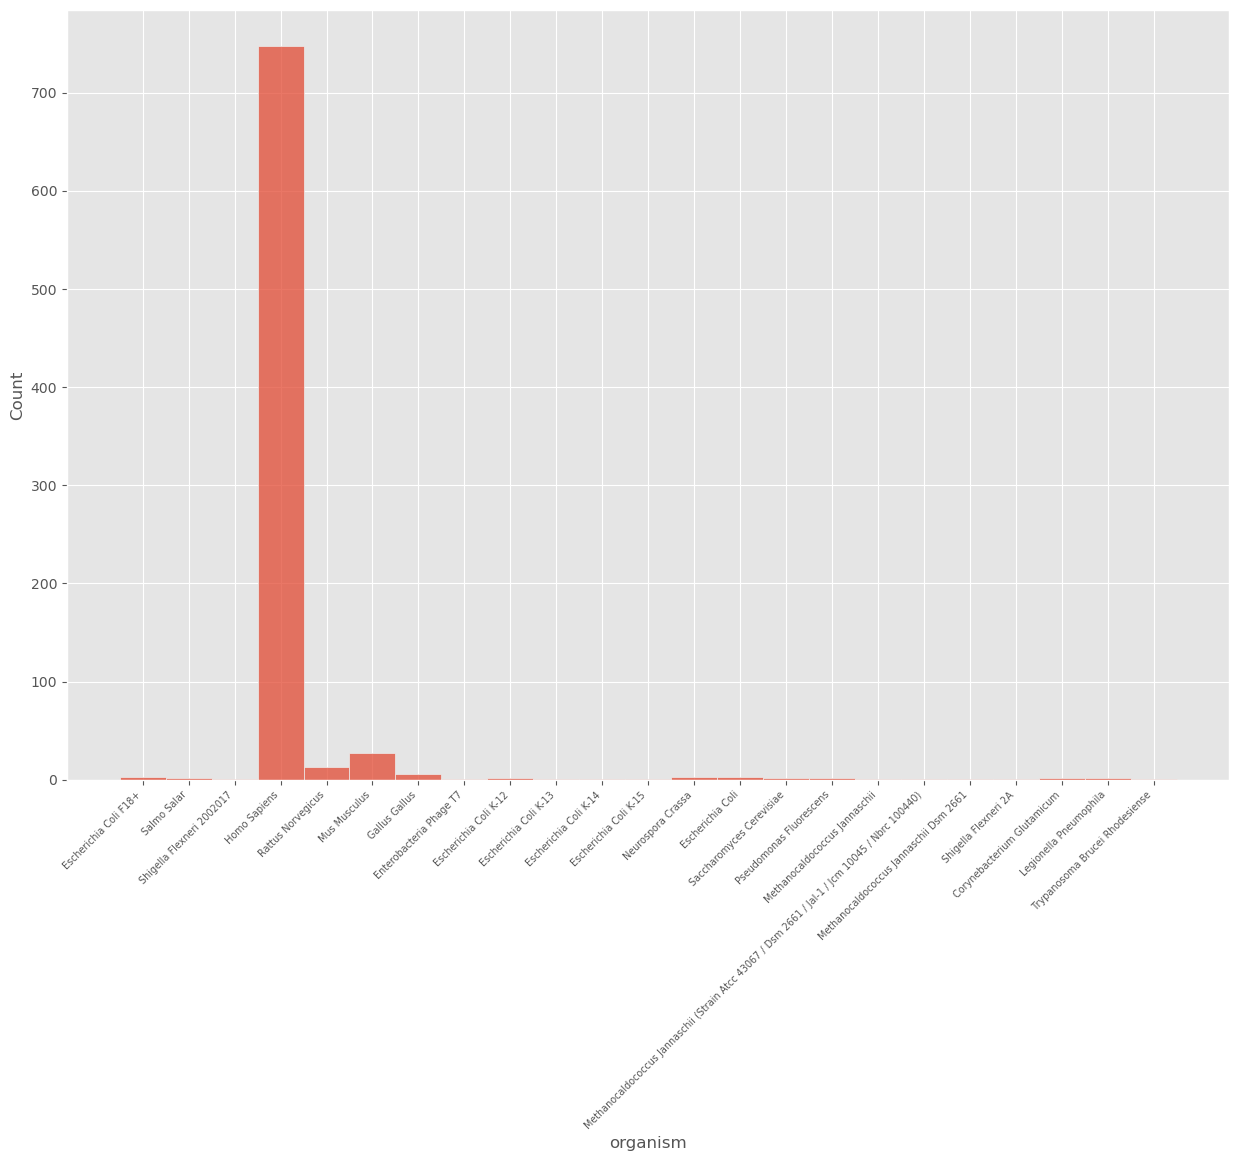

<Figure size 640x480 with 0 Axes>

In [4]:
'''
Determining the species distribution for our proteins.
'''

df = pd.read_csv('./project_pipeline/data/classified_files_3.tsv', sep='\t').astype('object')

df['organism'] = df['organism'].str.strip('"').str.title()

# Make the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
sns.histplot(data=df, x='organism', ax=ax)
plt.xticks(rotation=45, fontsize='x-small', ha='right')

plt.show()
plt.savefig('./project_pipeline/data/figures/organism_distribution.png')

/tmp/ipykernel_302405/1197176586.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_closed['diff'] = ['small' if x <= 2.5 else 'large' for x in df_closed['2_comp']]
/tmp/ipykernel_302405/1197176586.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_closed['diff'] = df_closed['diff'].astype('category')
/tmp/ipykernel_302405/1197176586.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<Axes: xlabel='conformation', ylabel='Count'>

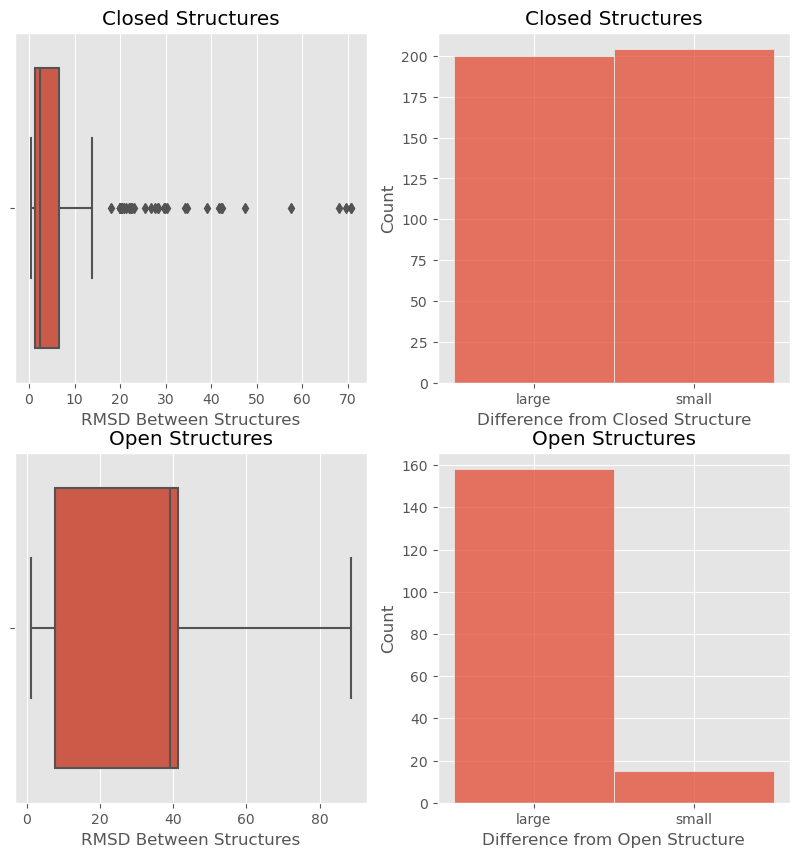

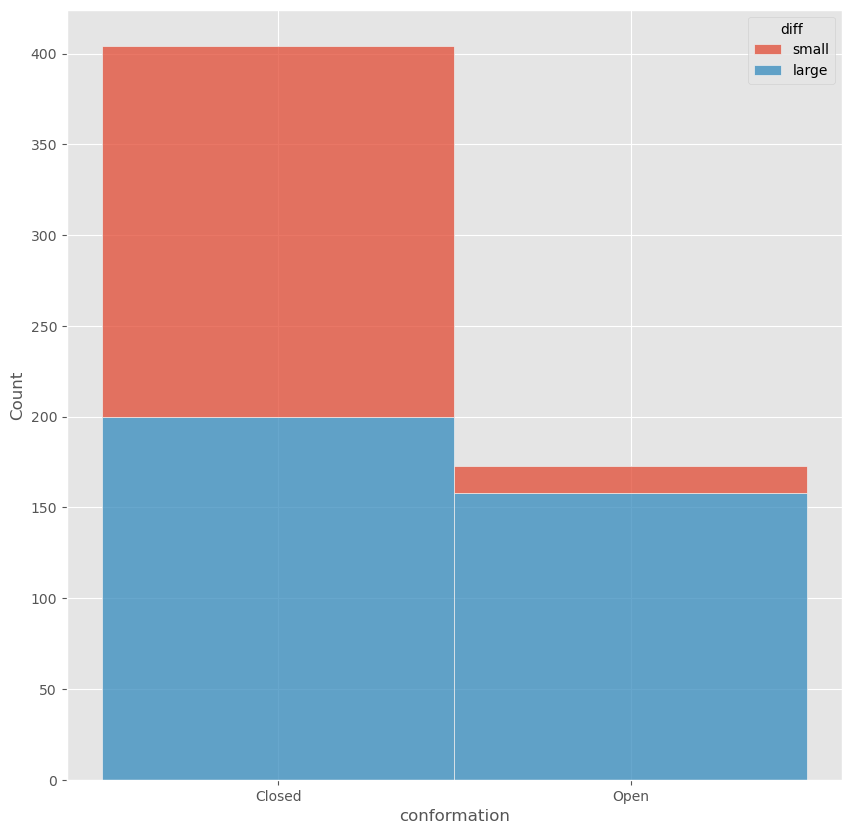

In [20]:
df = df.astype({'2_comp': 'float'})

# remove outlier
df = df[df['2_comp'] < 150].reset_index(drop=True)

# Define the different dataframes
df_active = df[df['state'] == 'Active']
df_autoin = df[df['state'] == 'Autoinhibited']
df_open = df[df['conformation'] == 'Open']
df_closed = df[df['conformation'] == 'Closed']


# Annotate whether structure is within 2.5 A of the closed structured
df_closed['diff'] = ['small' if x <= 2.5 else 'large' for x in df_closed['2_comp']]
df_closed['diff'] = df_closed['diff'].astype('category')

# Annotate whether structure is greater than 2.5 A from the open structure
df_open['diff'] = ['small' if x <= 2.5 else 'large' for x in df_open['2_comp']]
df_open['diff'] = df_open['diff'].astype('category')

df_full = pd.concat([df_closed, df_open])

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.boxplot(data=df_closed, x='2_comp', ax=axes[0][0])
axes[0][0].set_title('Closed Structures')
axes[0][0].set_xlabel('RMSD Between Structures')

# Plot the counts of small and large differences for the closed structures
sns.histplot(data=df_closed, x='diff', ax=axes[0][1])
axes[0][1].set_title('Closed Structures')
axes[0][1].set_xlabel('Difference from Closed Structure')

sns.boxplot(data=df_open, x='2_comp', ax=axes[1][0])
axes[1][0].set_title('Open Structures')
axes[1][0].set_xlabel('RMSD Between Structures')

# Plot the counts of small and large differences for the open structures
sns.histplot(data=df_open, x='diff', ax=axes[1][1])
axes[1][1].set_title('Open Structures')
axes[1][1].set_xlabel('Difference from Open Structure')


# Plot for count for the full dataframe
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.histplot(data=df_full, x='conformation', hue='diff', multiple='stack', hue_order = ['small', 'large'], ax=axes)

<Axes: xlabel='year', ylabel='Count'>

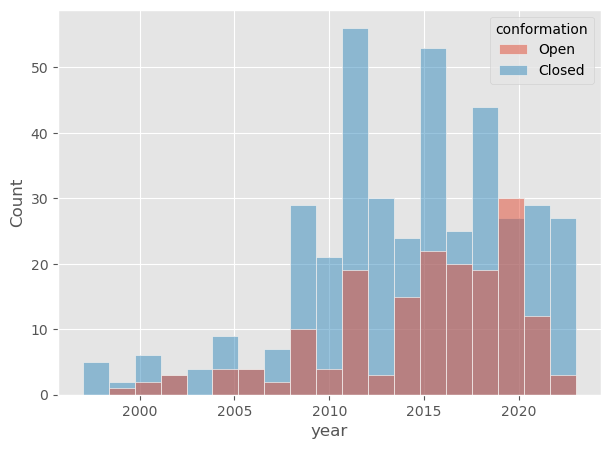

In [7]:
# Categorize by date
# Clean the date column
df['date'] = df['date'].str.strip('['']')
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# Plot the count of structures by year
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
sns.histplot(data=df, x='year', hue='conformation', ax=axes)

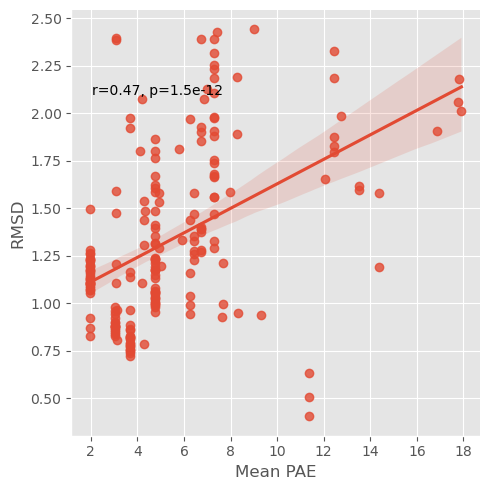

In [15]:
'''
Examine correlation between predicted aligned error when comparing regions 1 and 2 and the RMSD between the structures 
on the subset of closed proteins with RMSD < 2.5 A
'''

df_dis = pd.read_csv('./project_pipeline/data/disorder.tsv', sep='\t').astype('object')

df_closed = [row for index, row in df_dis.iterrows() if row['conformation'] == 'Closed']
df_closed = pd.DataFrame(df_closed)

df_closed['2_comp'] = df_closed['2_comp'].astype('float')
df_closed['diff'] = ['small' if x <= 2.5 else 'large' for x in df_closed['2_comp']]

df_small = [row for index, row in df_closed.iterrows() if row['diff'] == 'small']
df_small = pd.DataFrame(df_small)

# Plot the correlation between the aligned error and the RMSD
g = sns.lmplot(data=df_small, x='mean_pae_1_2', y='2_comp')
g.set_axis_labels('Mean PAE', 'RMSD')
g.set_titles('RMSD vs. Mean PAE for Closed Structures with RMSD < 2.5 A')

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['2_comp'], data['mean_pae_1_2'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
